In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.030572 -0.444462 -0.267516 -0.306704  0.080846  0.515975  0.420168   
  1   0.277272  0.853036 -0.942573 -0.321789 -0.279730  0.522790  0.583691   
  2  -0.260609  0.513154 -0.430573  0.138347 -1.191529 -0.912634  0.071126   
  3   0.923901  0.051989  0.105887 -0.449165  0.023094  0.328602  0.191271   
  4   0.629027  0.617413 -0.347805 -0.928457 -0.534832 -0.076026 -0.689926   
  5   0.368033  0.153063  0.813008 -0.195758  0.569135 -1.911321 -1.919220   
  6   0.847515  1.024968  0.987513 -0.185865  0.235301 -0.326468 -0.167352   
  7  -0.651643  0.033978 -0.216506  0.643662  0.141099 -0.543581 -0.326884   
  8   0.757892  1.188512  0.700639 -0.082220  0.961191  0.208173 -0.516640   
  9  -0.332960 -0.578257 -0.504793  0.067650 -0.719637 -0.492875  0.345460   
  10  0.157049 -0.064421  0.669122 -0.006789 -0.802829 -0.101890  1.083873   
  11  0.444533  0.724974  0.650242  0.426200 -0.274104 -0.280977  0.116279   
  12  0.696109  1.001555 -1.297698  0.615005 -0.329091 -0.723441 -0.353361   
  13 -0.928485 -0.996811  0.125610  0.797028  0.015361 -0.554745 -0.241680   
  14  0.509505  0.912714 -0.590360 -0.205326 -0.336323 -0.436948  0.564173   
  15  1.348779  1.392549  1.450658  1.197891  0.184234 -0.888549 -0.744236   
  16  0.659547 -0.235150  0.522048  0.644442  1.080489  0.481982 -1.196486   
  17 -0.137622  0.198560 -0.471409 -0.962627 -0.829680 -0.454459  0.354595   
  18  0.158171  0.160212  0.732994  0.489838 -0.576994 -0.304770 -0.780403   
  19  0.307403  1.175178  0.574138  0.596145  1.187788 -0.584305 -1.148300   
  20  0.293058  0.089830  0.585689  0.221630 -0.625934 -0.077013 -0.815292   
  21 -0.787904  0.246220  0.652939 -0.375031 -0.008996  0.211046  1.011019   
  22  1.171727  0.828701 -0.111789  0.433775 -0.379211 -0.387727 -0.595686   
  23 -0.147755  0.092964 -0.469491 -0.410205 -0.798103 -0.093871 -0.030190   
  24  0.534786  1.552590  0.128751 -0.494648 -0.354813 -0.121617  0.411184   
1 0   0.147959 -0.375006 -0.454214 -0.013758  0.107554 -0.798497 -0.546005   
  1  -0.136910 -0.208997 -0.751249  0.059697 -0.173504  0.252840  0.082209   
  2  -0.082762 -0.204666 -0.630149 -0.861188 -0.404153 -0.248849 -0.287872   
  3  -0.246143 -0.671003 -0.925778 -0.450072  0.604727  0.865915  0.641991   
  4  -0.342741 -0.039835 -0.181840 -0.760825 -0.246101  0.059203 -0.448300   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.237405  0.233662  0.311332  ...  0.062598  1.549216 -0.132179   
  1   1.353647  1.543607  0.467262  ...  0.241726  1.064844 -0.366268   
  2   0.104540  0.308365  0.739302  ...  0.254929 -0.316515  0.112810   
  3   1.891729 -0.409269  1.092523  ...  0.573111  1.475728  0.643783   
  4   0.420464  0.313343 -0.113402  ... -0.193473  0.708810  0.535751   
  5  -0.016353  0.122468  0.701365  ... -0.288420  0.389256  0.370641   
  6   0.516004 -0.377188 -0.380749  ... -0.451513  1.046698  0.401598   
  7   0.498750  0.200973  0.245409  ...  0.556691 -0.564197  0.014828   
  8   0.329004  0.020798 -0.193076  ... -0.264668  0.101383 -0.908501   
  9   0.383775 -0.560838 -0.096737  ... -1.715477 -0.285555 -0.766340   
  10  1.298282 -0.313717  0.252166  ...  0.105970  1.524782  0.413520   
  11 -0.052146  0.001567 -0.248833  ...  0.275882 -0.004487 -0.984697   
  12  0.838236 -0.755818  0.352885  ... -0.134089  0.540289 -0.144417   
  13  0.410006 -0.077413 -0.622621  ...  0.570019  1.127775  0.091317   
  14 -0.105002 -0.184369  0.014441  ... -0.140704  0.673468 -1.023678   
  15 -0.090332 -0.115020 -0.003423  ... -0.662537  0.643767  0.583883   
  16 -0.928878  0.407641  0.215571  ... -0.641684 -0.245899 -0.151555   
  17  0.753980 -0.184369 -0.237960  ...  0.412192  0.146913  0.849806   
  18  0.711139 -0.551386 -0.365324  ... -0.583754  0.826080  0.779042   
  19  1.354243  0.024268  0.281874  ... -0.090637 -0.233007  0.007518   
  20 -0.415369 -0.239053  0.347542  ...  0.209615  0.690738 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  0.982771  0.039264  25.029785  2.898630e-138  0.905814  1.059727


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



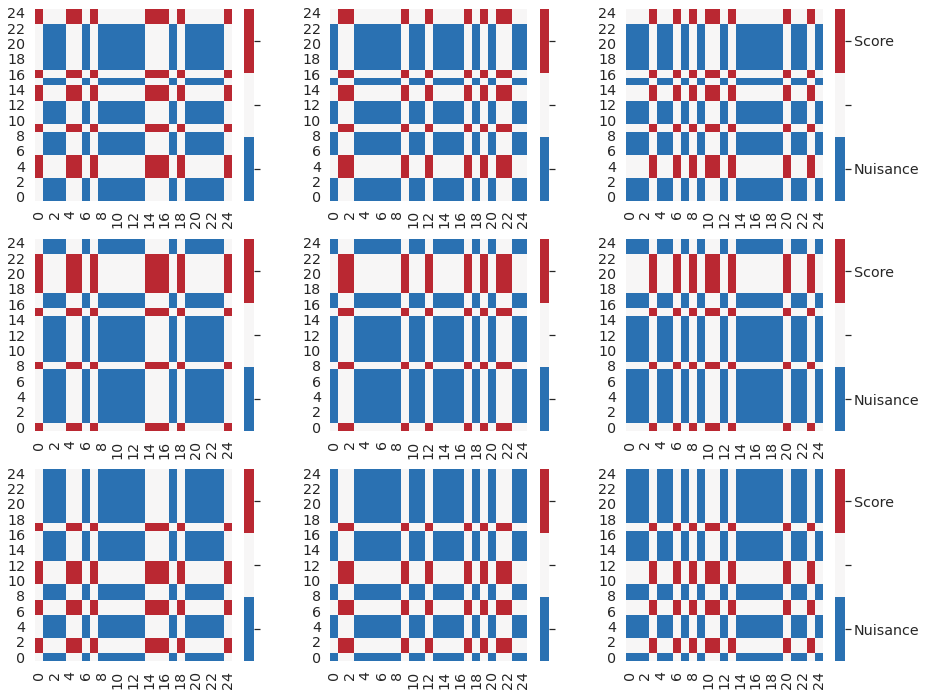

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



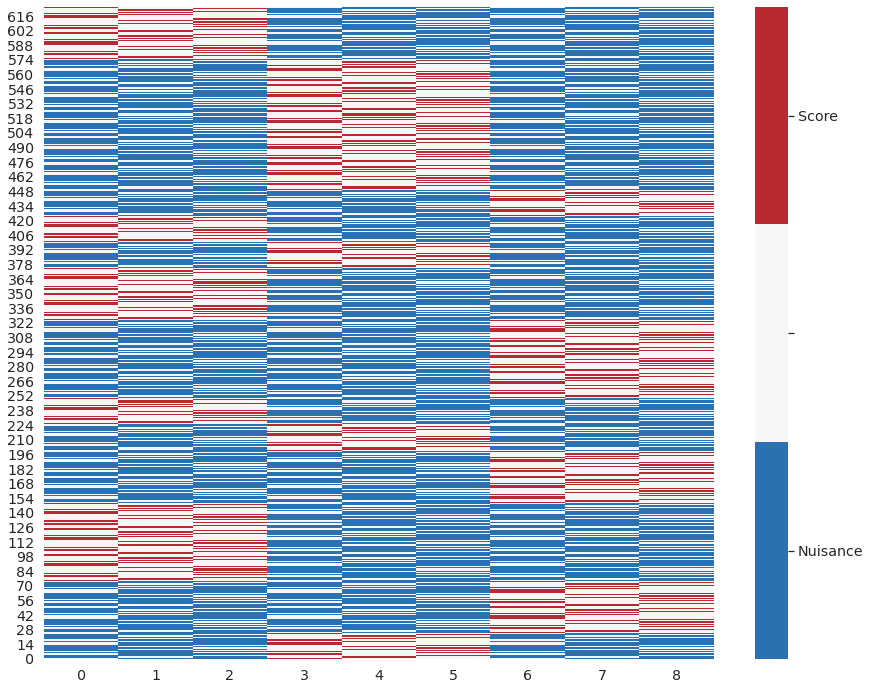

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])